In [8]:
from modules.search_engines import GoogleSearchEngine, DuckDuckGoSearchEngine
from modules.embedder import HuggingFaceEmbedder
import os
from dotenv import load_dotenv
import pandas as pd
from typing import List, Dict
from sklearn.metrics.pairwise import cosine_similarity
from urllib.parse import urlparse
from modules.help import load_credible_domains
from modules.prefilter import prefilter_results
from modules.llm_base import LLM, build_classification_prompt

In [3]:
load_dotenv()

True

## Import Dataset

In [4]:
fake_df = pd.read_csv('./data/Fake.csv')
true_df = pd.read_csv('./data/True.csv')

fake_df['class'] = 'fake'
true_df['class'] = 'true'

df = pd.concat([fake_df, true_df], axis=0)
df.shape, fake_df.shape, true_df.shape

((44898, 5), (23481, 5), (21417, 5))

## Main Code: Google API with llama 8b

In [6]:
title_1 = df['title'].iloc[0]

### Search

In [ ]:
API_KEY = os.getenv("GOOGLE_API_KEY")
search_engine = GoogleSearchEngine(API_KEY)

query = title_1
results = search_engine.search(query, num_results=10)

In [9]:
search_engine = DuckDuckGoSearchEngine()
query = title_1
results = search_engine.search(query, num_results=10)

### Check Similarity

In [10]:
embedder = HuggingFaceEmbedder(model_name="./models/distilbert-base-uncased")
results_filtered = prefilter_results(results, title_1, embedder)

### Get LLM Results

In [13]:
prompt = build_classification_prompt(title_1, results_filtered)

In [12]:
GROQ_API_KEY  = os.getenv("GROQ_API_KEY")
groq_llm = LLM(
    model="llama-3.1-8b-instant",            # substitua pelo modelo correto da Groq
    api_key_env="GROQ_API_KEY",
    endpoint="https://api.groq.com/openai/v1/chat/completions"  # endpoint da Groq
)

groq_llm.generate(prompt=prompt, temperature=0.0)

c:\Users\mwuillau\OneDrive - Nokia\UFRJ\LLMs\Fake-News-Detector\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.groq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'fake'

## Full run: llama 3.1 8B ; Duck Duck Go ; Embbeding Reduction

In [41]:
from tqdm import tqdm  
queries = df['title'].sample(2000, random_state=42)

search_engine = DuckDuckGoSearchEngine()
embedder = HuggingFaceEmbedder(model_name="./models/distilbert-base-uncased")

# Initialize Groq LLM
GROQ_API_KEY  = os.getenv("GROQ_API_KEY")
groq_llm = LLM(
    model="llama-3.1-8b-instant",
    api_key_env="GROQ_API_KEY",
    endpoint="https://api.groq.com/openai/v1/chat/completions"
)

results_list = []

for title in tqdm(queries, desc="Processing titles"):
    # 1️⃣ Search
    results = search_engine.search(title, num_results=10)
    
    # 2️⃣ Prefilter
    results_filtered = prefilter_results(results, title, embedder)
    
    # Count how many results were kept
    filtered_count = len(results_filtered)
    
    # 3️⃣ Build prompt
    prompt = build_classification_prompt(title, results_filtered)
    
    # 4️⃣ Call LLM
    try:
        response = groq_llm.generate(prompt=prompt, temperature=0.0)
        results_list.append({
            "title": title,
            "llm_output": response,
            "filtered_count": filtered_count
        })
    except Exception as e:
        print(f"Error for title: {title} -> {e}")
        results_list.append({
            "title": title,
            "llm_output": None,
            "filtered_count": filtered_count
        })

Processing titles:   0%|          | 0/2000 [00:00<?, ?it/s]c:\Users\mwuillau\OneDrive - Nokia\UFRJ\LLMs\Fake-News-Detector\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.groq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Processing titles:   0%|          | 1/2000 [00:01<1:05:38,  1.97s/it]c:\Users\mwuillau\OneDrive - Nokia\UFRJ\LLMs\Fake-News-Detector\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.groq.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Processing titles:   0%|          | 2/2000 [00:03<54:33,  1.64s/it]  c:\Users\mwuillau\OneDrive - Nokia\UFRJ\LLMs\Fake-News-Detector\.venv\Lib\site-packages\url

In [42]:
results_df = pd.DataFrame(results_list)
results_df.to_csv('./data/llama3_70B_duck_baseline.csv', sep='|', index=False)

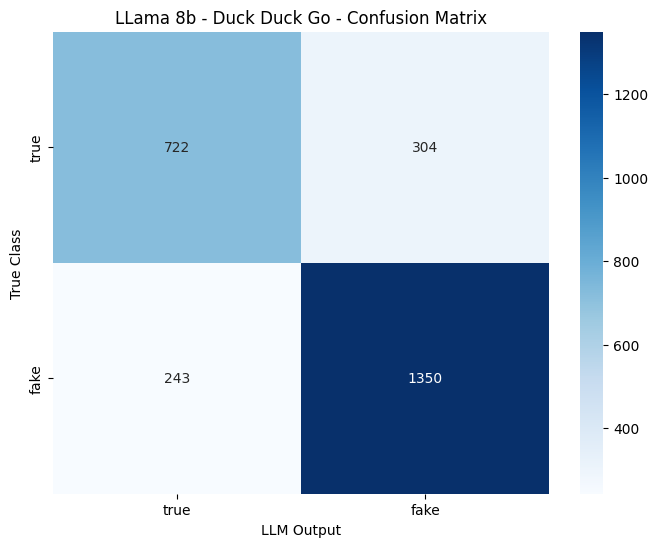

              precision    recall  f1-score   support

        fake       0.82      0.85      0.83      1593
        true       0.75      0.70      0.73      1026

    accuracy                           0.79      2619
   macro avg       0.78      0.78      0.78      2619
weighted avg       0.79      0.79      0.79      2619



In [44]:
results_df = pd.DataFrame(results_list)
merged_df = results_df.merge(
    df[df['title'].isin(queries.tolist())][['title', 'class']], 
    on='title'
)

# Make sure LLM outputs and true classes are aligned
y_true = merged_df['class']
y_pred = merged_df['llm_output']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=y_true.unique())
cm_df = pd.DataFrame(cm, index=y_true.unique(), columns=y_true.unique())

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True Class')
plt.xlabel('LLM Output')
plt.title('LLama 8b - Duck Duck Go - Confusion Matrix')
plt.show()

# Optional: print classification report
print(classification_report(y_true, y_pred))